My ultimate goal is to build a neural network to predict lung cancer diagnosis using the set over 1000 chest CT scans and associated diagnosis data provided in the Data Science Bowl 2017. This script contains pre-processing steps: loading the DICOM files (here I'm loading a sample of size 781 MB of the total 67 GB available), converting the pixel values in the images to Hounsfield Units (HU, a measure of radiodensity), deriving the slice thickness of each image, and resizing the images so that each voxel represents 1 mm^3 in real space. Finally, I will use multiple slices from individual patients' processed scans to disply a 3D image of their lung. Big thanks to Guido Zuidhof (https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/notebook) for his tutorial, which this code is based on. The data used in this analysis can be downloaded from here: https://www.kaggle.com/c/data-science-bowl-2017/data.

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../input/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
# This function will load the scan for a given patient and infer the slice thickness for each scan
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
# This function will convert pixels to Hounsfield Units
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices]) #make 3D arrays combining all slices for each patient 
    image = image.astype(np.int16) #convert to int16

    # Pixels that were outside the scanning bounds have been set to -2000
    # Reset to have HU of air = 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept #RescaleIntercept included in metadata of pic
        slope = slices[slice_number].RescaleSlope #RescaleIntercept included in metadata of pic
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Let's use these two functions to do some basic exploration of what data we have here. For this proof of concept EDA, I will be working with a subset of the patients. Here's the number of patients I will be working with, and how many slices each there are for each patient.

There are scans from 20 patients in this subset of the data.
167.5= median value of scan lengths


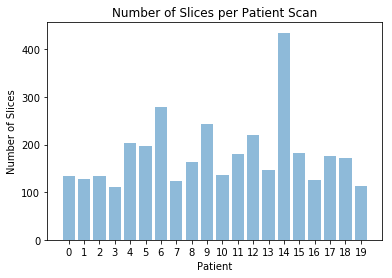

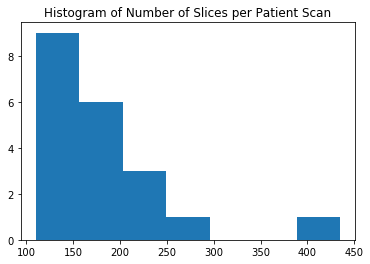

In [4]:
print("There are scans from " + str(len(patients)) + " patients in this subset of the data.")
scan_lens = []
for patient in patients:
    scan = load_scan(INPUT_FOLDER + patient)
    scan_lens.append(len(scan))
print(str(np.median(scan_lens)) + "= median value of scan lengths")

#display number of slices per patient scan in barplot
y_pos = np.arange(len(scan_lens))
 
plt.bar(y_pos, scan_lens, align='center', alpha=0.5)
plt.xticks(y_pos, np.arange(len(scan_lens)))
plt.ylabel('Number of Slices')
plt.xlabel('Patient')
plt.title('Number of Slices per Patient Scan')
 
plt.show()

plt.hist(scan_lens, bins='auto')
plt.title("Histogram of Number of Slices per Patient Scan")
plt.show()

In this sampling of 20 patients, all but one have between 100 and 300 slices,, with a median of 167.5 slices  per patient.

We need to resize all the images so that for every image, 1 voxel corresponds to approximately 1 mm^3 of lung. This will give the images "isomorphic resolution," which will allow us to train a convoluted neural network on them down the line.

In [6]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

Let's read in the scan for the first patient, resize it, and see how the shape of our image array changes when we do so. You'll see the shape of the image after resizing is much closer to an approximate 1:1:1.

In [7]:
# read scan from first patient
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_hu = get_pixels_hu(first_patient)

# resize the scan
first_patient_resampled, spacing = resample(first_patient_hu, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_hu.shape)
print("Shape after resampling\t", first_patient_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


It would be neat to visualize these scans in 3D. Following Zuidhof's tutorial, I will use the marching cubes method from the skimage package. The function plot_3d defined below takes an image (as a 3D array) and displays those parts of the image whose radiodensity in HU is above a certain threshold. This allows the user to choose which kinds of tissues to display in the visualization.

In [8]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _ , _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # `verts[faces]` generates a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

We can now visualize a patients scan in 3D. Let's do this for the first patient. We can use a threshold to limit the tissue type that we plot. We will use a threshold of 400 HU to limit the scan to displaying bone. 

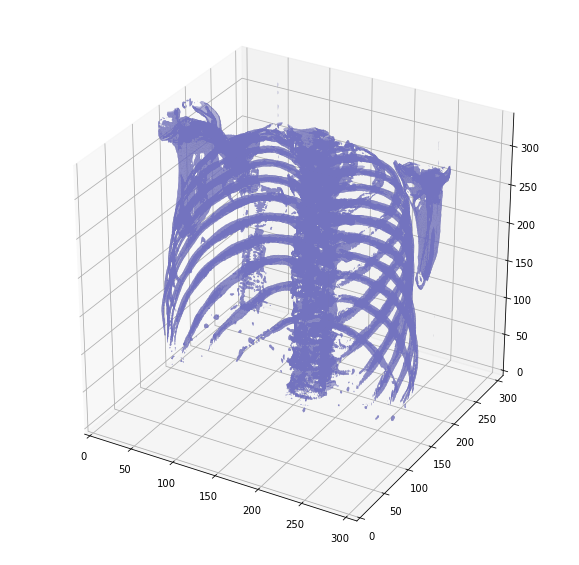

In [9]:
plot_3d(first_patient_resampled, 400)

If we up the HU threshold to 700, we limit the image to yet denser portions of the chest.

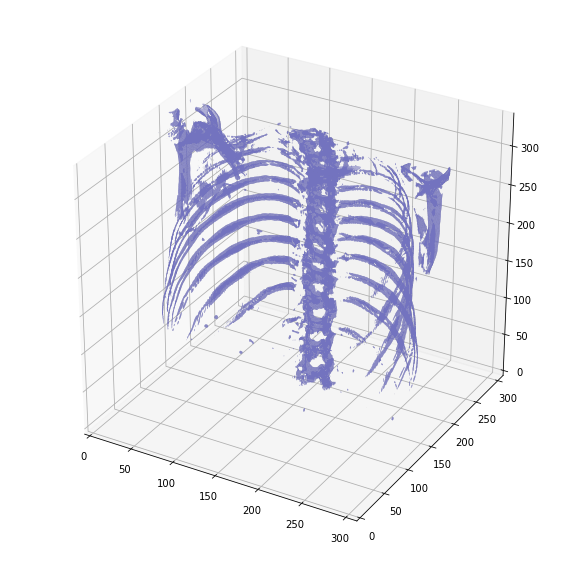

In [10]:
plot_3d(first_patient_resampled, 700)